In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

dataset = pd.read_csv('../../../data/preprocessed.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

In [3]:
dataset["DATETIME_INI"] = dataset["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
dataset["DATETIME_FIM"] = dataset["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [4]:
dataset.head()

,LOCDESCARREGO_ID,EMP_ID,ROTA_ID,TPVEICULO_DESC,PES_PESOUTIL,COLETA_ID,ESPECCOLETA_ID,PERCUSSO_I,LOCAL_ID,TPCIRCUITO_DESC,DATETIME_INI,DATETIME_FIM
PES_ID,,,,,,,,,,,,
2490322,7,708,144,3,9640,1,1,2156.0,205,0,1.420081e+09,1.420082e+09
2489495,7,708,144,3,9100,1,1,2156.0,205,0,1.419914e+09,1.419915e+09
2488707,7,708,144,3,3480,1,1,2156.0,205,0,1.419666e+09,1.419667e+09
2488660,7,708,144,3,9370,1,1,2156.0,205,0,1.419655e+09,1.419655e+09
2488114,7,708,144,3,9460,1,1,2156.0,205,0,1.419502e+09,1.419503e+09


In [5]:
target_column_name = 'PES_PESOUTIL'
target_column = dataset.pop(target_column_name)

In [6]:
X = dataset.to_numpy()
y = target_column.to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
params = {
    "max_depth": 50,
    "max_iter": 500,
    "learning_rate": 0.2,
    "loss": "squared_error",
}

In [17]:
reg = HistGradientBoostingRegressor(**params, categorical_features="from_dtype")
reg.fit(X_train, y_train)

HistGradientBoostingRegressor(categorical_features='from_dtype',
                              learning_rate=0.2, max_depth=50, max_iter=500)

In [18]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 5447409.4370


### Parameterizing

In [19]:
# from sklearn.model_selection import GridSearchCV
# # set up our search grid
# param_grid = {
#     "max_depth": [25, 50, 100],
#     "max_iter": [100, 250, 500],
#     "learning_rate": [0.1, 0.2, 0.3],
#     "loss": ["squared_error"]
# }

# hgb = HistGradientBoostingRegressor()

# # try out every combination of the above values
# search = GridSearchCV(hgb, param_grid, cv=10).fit(X_train, y_train)

# print("The best hyperparameters are ",search.best_params_)

## Cross-Validation

In [20]:
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True
                            )
    return scores

## Experimentation


In [21]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    scores.append(cross_validate_model(reg, X, y, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

### Training Duration

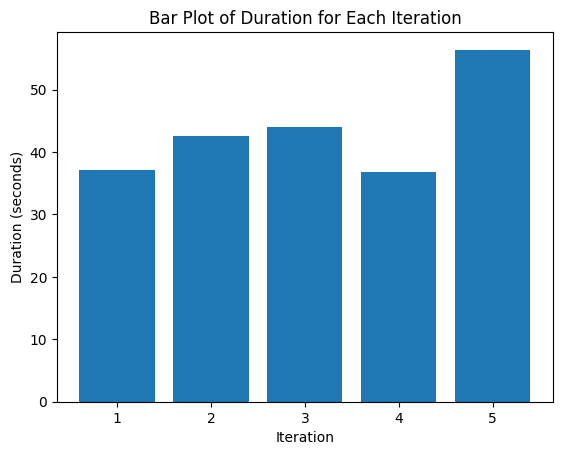

In [28]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()

time_training = np.mean(duration)
time_training_std = np.std(duration)

print(f"Training time: {time_training} ± {time_training_std} seconds")

### R2 Score

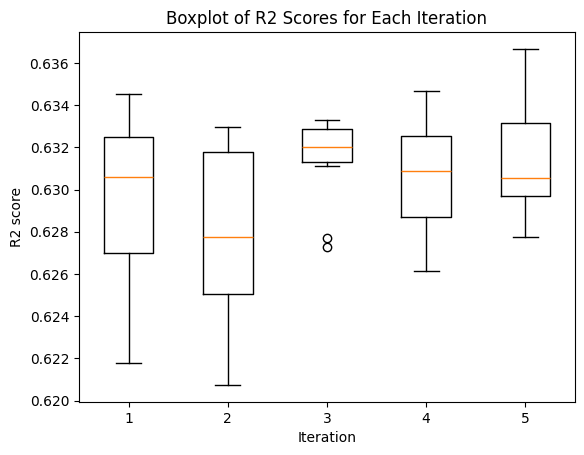

Mean R2 score: 0.6301
Standard deviation of R2 scores: 0.0036


In [29]:
r2_scores = [r2['test_r2'] for r2 in scores]

# Create a boxplot of the R2 scores for each iteration
plt.boxplot(r2_scores)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Boxplot of R2 Scores for Each Iteration')
plt.show()

# Calculate the mean and standard deviation of the R2 scores
r2_scores_mean = np.mean(r2_scores)
r2_scores_std = np.std(r2_scores)

print(f"Mean R2 score: {r2_scores_mean:.4f}")
print(f"Standard deviation of R2 scores: {r2_scores_std:.4f}")

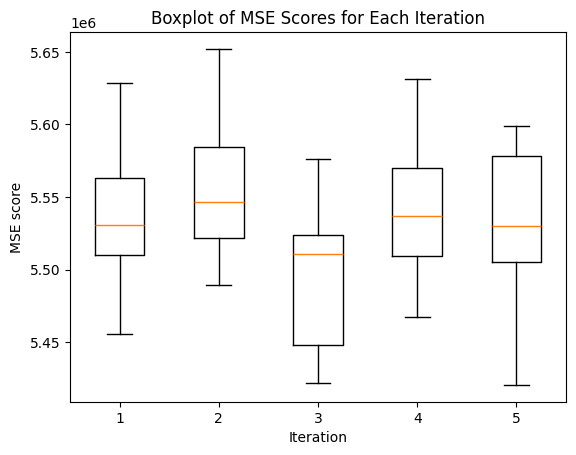

Mean MSE: 5531884.2811
Standard Deviation of MSE: 54293.8113


In [30]:
# Calculate MSE for each fold
mse_scores = [-mse['test_neg_mean_squared_error'] for mse in scores]
plt.boxplot(mse_scores)
plt.xlabel('Iteration')
plt.ylabel('MSE score')
plt.title('Boxplot of MSE Scores for Each Iteration')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean([mse.mean() for mse in mse_scores])
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

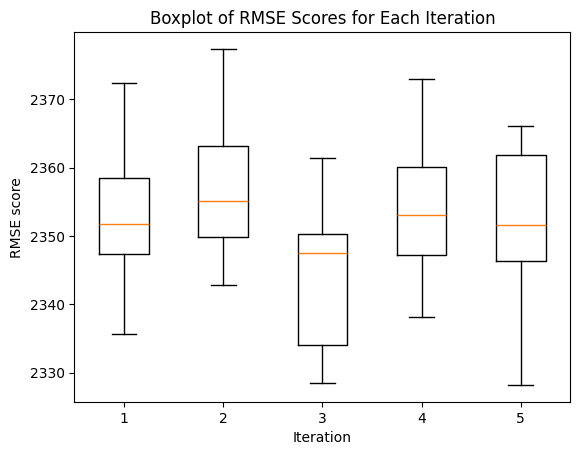

Mean RMSE: 2351.9675
Standard Deviation of RMSE: 11.5417


In [31]:
rmse_scores = [-rmse['test_neg_root_mean_squared_error'] for rmse in scores]

# Plot the RMSE scores
plt.boxplot(rmse_scores)
plt.xlabel('Iteration')
plt.ylabel('RMSE score')
plt.title('Boxplot of RMSE Scores for Each Iteration')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = np.mean([rmse.mean() for rmse in rmse_scores])
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))

## Exporting Metrics

In [ ]:
import os

# Define the filename for the metrics dataset
metrics_filename = "../results.csv"

# Check if the metrics.csv file exists
if os.path.exists(metrics_filename):
    # Load the metrics dataset
    metrics_dataset = pd.read_csv(metrics_filename, index_col='Algorithm')
    
    data = {
        "Mean R2 score": r2_scores_mean,
        "Standard deviation of R2 scores": r2_scores_std,
        "Mean MSE": mean_mse,
        "Standard deviation of MSE": std_mse,
        "Mean RMSE": mean_rmse,
        "Standard deviation of RMSE": std_rmse,
        "Mean Training time": time_training,
        "Standard deviation of Training time": time_training_std
    }
    
    df = pd.DataFrame(data, index=['HistGradientBoostingRegressor_preprocessed'])
    
    metrics_dataset = pd.concat([metrics_dataset, df], axis=0)
    
    # Save the updated metrics dataset
    metrics_dataset.to_csv(metrics_filename, index=True, index_label='Algorithm')
else:
    # The metrics.csv file does not exist, print an error message
    print("The metrics.csv file does not exist.")
